# Ablation Study Analysis: Loss Function Components

This notebook analyzes the checkpoints from different ablation configurations:
- **WMSE**: Weighted MSE loss only
- **WMSE + SSIM**: Adding SSIM loss component
- **WMSE + SSIM + Edge**: Adding edge-aware loss
- **WMSE + SSIM + Edge + Intensity**: Full loss configuration with intensity preservation

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [4]:
# Define checkpoint directories
CHECKPOINT_BASE = Path('src/renderer/checkpoints')

ablation_configs = {
    'WMSE': CHECKPOINT_BASE / 'checkpoints_wmse',
    'WMSE+SSIM': CHECKPOINT_BASE / 'checkpoints_wsme_ssim',
    'WMSE+SSIM+Edge': CHECKPOINT_BASE / 'train_swme_ssim_edge_checkpoint',
    'WMSE+SSIM+Edge+Inte': CHECKPOINT_BASE / 'train_swme_ssim_edge_inte_checkpoint',
}

# Actual total epochs trained (accounting for continued training)
actual_epochs = {
    'WMSE': 2000,
    'WMSE+SSIM': 2000,  # User trained 2000 epochs, JSON has 1500 (continued from WMSE)
    'WMSE+SSIM+Edge': 2000,
    'WMSE+SSIM+Edge+Inte': 2000,
}

# Load training histories
training_histories = {}
for name, path in ablation_configs.items():
    history_file = path / 'training_history.json'
    if history_file.exists():
        with open(history_file, 'r') as f:
            training_histories[name] = json.load(f)
        recorded = len(training_histories[name])
        actual = actual_epochs.get(name, recorded)
        if recorded != actual:
            print(f"Loaded {name}: {recorded} epochs in JSON (trained {actual} epochs total)")
        else:
            print(f"Loaded {name}: {recorded} epochs")
    else:
        print(f"Warning: {history_file} not found")

Loaded WMSE: 2000 epochs
Loaded WMSE+SSIM: 1500 epochs in JSON (trained 2000 epochs total)
Loaded WMSE+SSIM+Edge: 2000 epochs
Loaded WMSE+SSIM+Edge+Inte: 2000 epochs


## 1. Final Performance Metrics (Best Checkpoint)

In [7]:
# Extract best metrics for each configuration
def get_best_metrics(history, config_name=None):
    """Extract best metrics from training history."""
    df = pd.DataFrame(history)
    
    # Find best epoch by PSNR
    best_idx = df['psnr'].idxmax()
    best_metrics = df.iloc[best_idx].to_dict()
    best_epoch = best_idx + 1  # 1-indexed
    
    # WMSE+SSIM was continued from WMSE epoch 500, so add offset
    if config_name == 'WMSE+SSIM':
        best_epoch += 500
    
    best_metrics['best_epoch'] = best_epoch
    
    # Also add final epoch metrics
    final_metrics = df.iloc[-1].to_dict()
    for key in ['psnr', 'ssim', 'mae', 'loss']:
        best_metrics[f'final_{key}'] = final_metrics.get(key)
    
    return best_metrics

# Build comparison table
results = []
for name, history in training_histories.items():
    metrics = get_best_metrics(history, config_name=name)
    metrics['Configuration'] = name
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Configuration')
results_df

,loss,mse,psnr,ssim,mae,scale_reg,n_visible,best_epoch,final_psnr,final_ssim,final_mae,final_loss,val_psnr,val_ssim,val_mae,edge,sparsity
Configuration,,,,,,,,,,,,,,,,,
WMSE,0.000508,0.000501,38.140831,0.990364,0.002917,0.000006,47817.0,2000,38.140831,0.990364,0.002917,0.000508,NaN,NaN,NaN,NaN,NaN
WMSE+SSIM,0.001764,0.000525,38.141538,0.993903,0.002580,0.000020,47564.0,1994,38.141286,0.993903,0.002580,0.001764,NaN,NaN,NaN,NaN,NaN
WMSE+SSIM+Edge,0.001871,0.000548,37.960065,0.993736,0.002630,0.000020,47564.0,1996,37.959850,0.993736,0.002630,0.001871,NaN,NaN,NaN,0.00050,0.000000
WMSE+SSIM+Edge+Inte,0.001841,0.000496,38.390277,0.994359,0.002510,0.000016,41472.0,1991,38.387495,0.994352,0.002511,0.001843,NaN,NaN,NaN,0.00045,0.000156


In [8]:
# Create formatted ablation study table
table_columns = ['psnr', 'ssim', 'mae', 'loss', 'best_epoch']
table_df = results_df[table_columns].copy()
table_df.columns = ['PSNR (dB) ↑', 'SSIM ↑', 'MAE ↓', 'Loss ↓', 'Best Epoch']

# Format values
table_df['PSNR (dB) ↑'] = table_df['PSNR (dB) ↑'].apply(lambda x: f"{x:.2f}")
table_df['SSIM ↑'] = table_df['SSIM ↑'].apply(lambda x: f"{x:.4f}")
table_df['MAE ↓'] = table_df['MAE ↓'].apply(lambda x: f"{x:.5f}")
table_df['Loss ↓'] = table_df['Loss ↓'].apply(lambda x: f"{x:.5f}")

print("\n" + "="*80)
print("ABLATION STUDY: Loss Function Components")
print("="*80)
print(table_df.to_string())
print("="*80)


ABLATION STUDY: Loss Function Components
                    PSNR (dB) ↑  SSIM ↑    MAE ↓   Loss ↓  Best Epoch
Configuration                                                        
WMSE                      38.14  0.9904  0.00292  0.00051        2000
WMSE+SSIM                 38.14  0.9939  0.00258  0.00176        1994
WMSE+SSIM+Edge            37.96  0.9937  0.00263  0.00187        1996
WMSE+SSIM+Edge+Inte       38.39  0.9944  0.00251  0.00184        1991


In [9]:
# Display as styled DataFrame
styled_table = table_df.style.set_caption(
    "<b>Table 1:</b> Ablation Study Results - Impact of Loss Function Components"
).set_table_styles([
    {'selector': 'caption', 'props': 'font-size: 1.2em; font-weight: bold; padding: 10px 0;'},
])
styled_table

,PSNR (dB) ↑,SSIM ↑,MAE ↓,Loss ↓,Best Epoch
Configuration,,,,,
WMSE,38.14,0.9904,0.00292,0.00051,2000
WMSE+SSIM,38.14,0.9939,0.00258,0.00176,1994
WMSE+SSIM+Edge,37.96,0.9937,0.00263,0.00187,1996
WMSE+SSIM+Edge+Inte,38.39,0.9944,0.00251,0.00184,1991


## 2. Training Curves Comparison

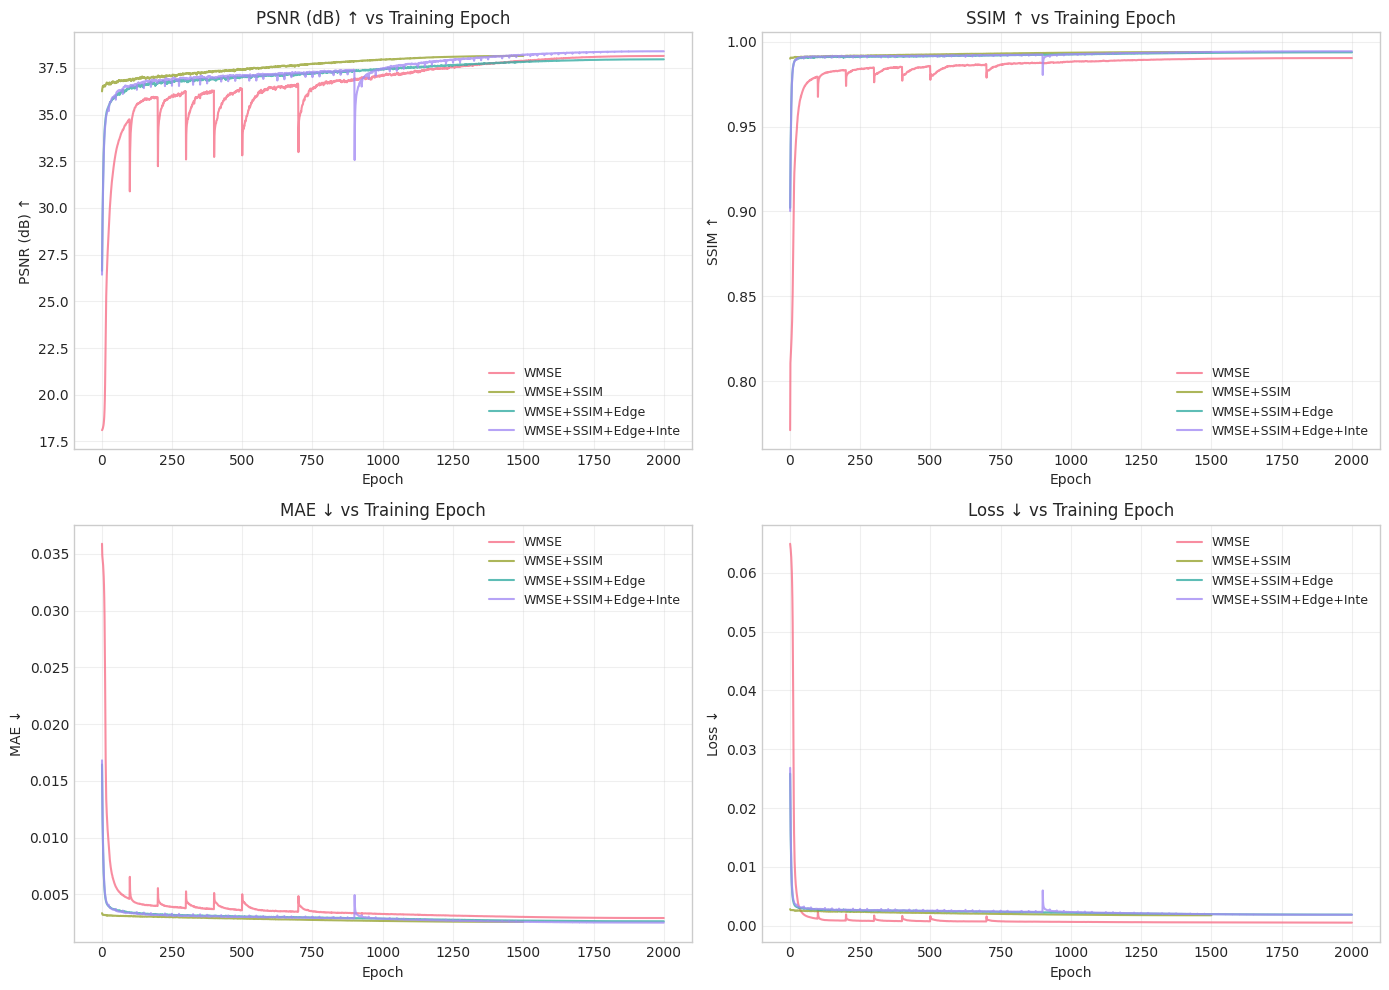

In [10]:
# Plot training curves for all configurations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['psnr', 'ssim', 'mae', 'loss']
titles = ['PSNR (dB) ↑', 'SSIM ↑', 'MAE ↓', 'Loss ↓']
colors = sns.color_palette('husl', len(training_histories))

for ax, metric, title in zip(axes.flat, metrics_to_plot, titles):
    for i, (name, history) in enumerate(training_histories.items()):
        df = pd.DataFrame(history)
        if metric in df.columns:
            # Apply smoothing
            values = df[metric].values
            ax.plot(range(1, len(values)+1), values, label=name, color=colors[i], alpha=0.8, linewidth=1.5)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.set_title(f'{title} vs Training Epoch')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Convergence Analysis

In [11]:
# Analyze convergence speed
convergence_analysis = []

# Define thresholds for convergence (e.g., PSNR at 95% of best)
for name, history in training_histories.items():
    df = pd.DataFrame(history)
    best_psnr = df['psnr'].max()
    
    # Find epoch where PSNR reaches 95% of best
    threshold_95 = best_psnr * 0.95
    epochs_to_95 = df[df['psnr'] >= threshold_95].index[0] + 1 if any(df['psnr'] >= threshold_95) else len(df)
    
    # Find epoch where PSNR reaches 99% of best
    threshold_99 = best_psnr * 0.99
    epochs_to_99 = df[df['psnr'] >= threshold_99].index[0] + 1 if any(df['psnr'] >= threshold_99) else len(df)
    
    convergence_analysis.append({
        'Configuration': name,
        'Best PSNR': best_psnr,
        'Best SSIM': df['ssim'].max(),
        'Epochs to 95%': epochs_to_95,
        'Epochs to 99%': epochs_to_99,
        'Total Epochs': actual_epochs.get(name, len(df)),  # Use actual epochs, not len(df)
    })

convergence_df = pd.DataFrame(convergence_analysis).set_index('Configuration')
print("Convergence Analysis:")
convergence_df

Convergence Analysis:


,Best PSNR,Best SSIM,Epochs to 95%,Epochs to 99%,Total Epochs
Configuration,,,,,
WMSE,38.140831,0.990366,298,1395,2000
WMSE+SSIM,38.141538,0.993903,1,785,2000
WMSE+SSIM+Edge,37.960065,0.993736,52,1165,2000
WMSE+SSIM+Edge+Inte,38.390277,0.994359,78,1286,2000


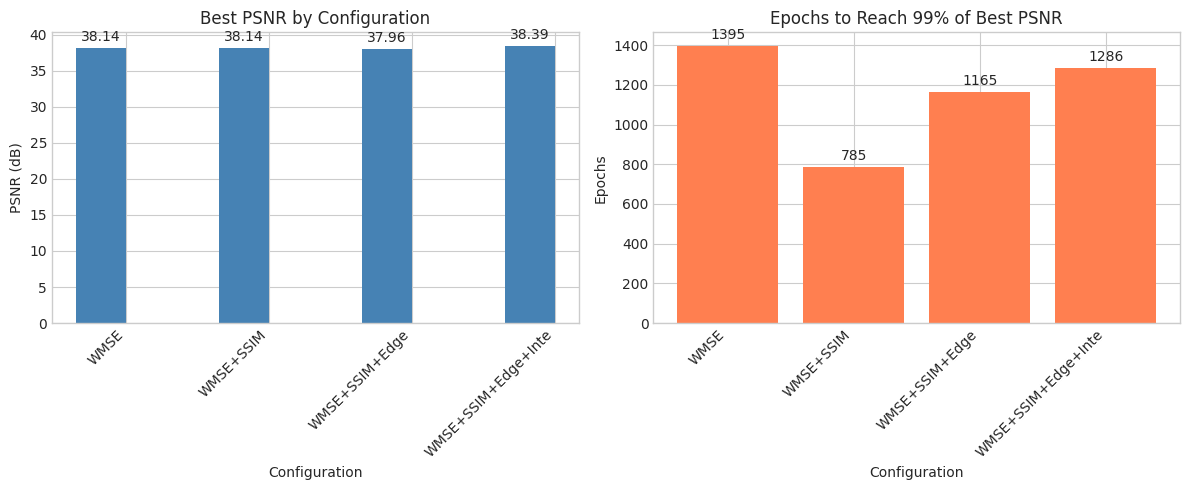

In [12]:
# Bar chart for convergence comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Best metrics comparison
ax1 = axes[0]
x = np.arange(len(convergence_df))
width = 0.35

bars1 = ax1.bar(x - width/2, convergence_df['Best PSNR'], width, label='PSNR (dB)', color='steelblue')
ax1.set_ylabel('PSNR (dB)')
ax1.set_xlabel('Configuration')
ax1.set_title('Best PSNR by Configuration')
ax1.set_xticks(x)
ax1.set_xticklabels(convergence_df.index, rotation=45, ha='right')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Convergence speed comparison
ax2 = axes[1]
bars2 = ax2.bar(x, convergence_df['Epochs to 99%'], color='coral')
ax2.set_ylabel('Epochs')
ax2.set_xlabel('Configuration')
ax2.set_title('Epochs to Reach 99% of Best PSNR')
ax2.set_xticks(x)
ax2.set_xticklabels(convergence_df.index, rotation=45, ha='right')

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('ablation_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Component-wise Contribution Analysis

In [13]:
# Calculate improvements from adding each component
configs = list(training_histories.keys())
improvements = []

for i in range(1, len(configs)):
    prev_config = configs[i-1]
    curr_config = configs[i]
    
    prev_best = get_best_metrics(training_histories[prev_config])
    curr_best = get_best_metrics(training_histories[curr_config])
    
    psnr_gain = curr_best['psnr'] - prev_best['psnr']
    ssim_gain = curr_best['ssim'] - prev_best['ssim']
    mae_reduction = prev_best['mae'] - curr_best['mae']
    
    improvements.append({
        'Added Component': curr_config.replace(prev_config.split('+')[0] + ('+' if '+' in prev_config else ''), '').lstrip('+'),
        'From': prev_config,
        'To': curr_config,
        'PSNR Gain (dB)': psnr_gain,
        'SSIM Gain': ssim_gain,
        'MAE Reduction': mae_reduction,
    })

improvements_df = pd.DataFrame(improvements)
print("\nComponent-wise Contribution:")
improvements_df


Component-wise Contribution:


,Added Component,From,To,PSNR Gain (dB),SSIM Gain,MAE Reduction
0,SSIM,WMSE,WMSE+SSIM,0.000706,0.003539,0.000337
1,SSIM+Edge,WMSE+SSIM,WMSE+SSIM+Edge,-0.181472,-0.000167,-0.000050
2,SSIM+Edge+Inte,WMSE+SSIM+Edge,WMSE+SSIM+Edge+Inte,0.430212,0.000623,0.000120


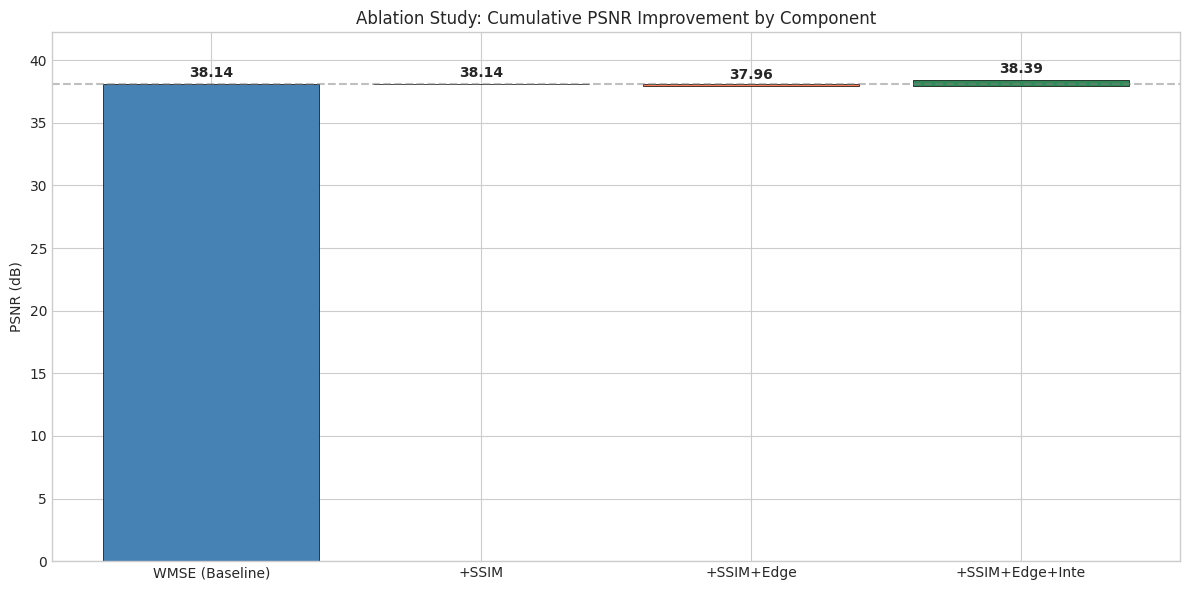

In [14]:
# Visualize improvements as a waterfall chart
fig, ax = plt.subplots(figsize=(12, 6))

# Get baseline PSNR
baseline_psnr = get_best_metrics(training_histories['WMSE'])['psnr']
psnr_values = [baseline_psnr]
labels = ['WMSE (Baseline)']
gains = [baseline_psnr]
colors_waterfall = ['steelblue']

for _, row in improvements_df.iterrows():
    psnr_values.append(psnr_values[-1] + row['PSNR Gain (dB)'])
    labels.append(f"+{row['Added Component']}")
    gains.append(row['PSNR Gain (dB)'])
    colors_waterfall.append('seagreen' if row['PSNR Gain (dB)'] > 0 else 'coral')

x = np.arange(len(labels))
bottom = [0] + psnr_values[:-1]

bars = ax.bar(x, gains, bottom=bottom, color=colors_waterfall, edgecolor='black', linewidth=0.5)

# Add cumulative PSNR labels
for i, (xi, yi) in enumerate(zip(x, psnr_values)):
    ax.annotate(f'{yi:.2f}', xy=(xi, yi), xytext=(0, 5),
                textcoords='offset points', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_ylabel('PSNR (dB)')
ax.set_title('Ablation Study: Cumulative PSNR Improvement by Component')
ax.axhline(y=baseline_psnr, color='gray', linestyle='--', alpha=0.5, label='Baseline')
ax.set_ylim(0, max(psnr_values) * 1.1)

plt.tight_layout()
plt.savefig('ablation_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary Table (Publication Ready)

In [15]:
# Create publication-ready table
summary_data = []
for name, history in training_histories.items():
    metrics = get_best_metrics(history)
    
    # Parse components
    components = {
        'L_MSE': '✓' if 'WMSE' in name else '',
        'L_SSIM': '✓' if 'SSIM' in name else '',
        'L_Edge': '✓' if 'Edge' in name else '',
        'L_Inte': '✓' if 'Inte' in name else '',
    }
    
    summary_data.append({
        **components,
        'PSNR (dB)': f"{metrics['psnr']:.2f}",
        'SSIM': f"{metrics['ssim']:.4f}",
        'MAE': f"{metrics['mae']:.5f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("PUBLICATION TABLE: Ablation Study Results")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)


PUBLICATION TABLE: Ablation Study Results
L_MSE L_SSIM L_Edge L_Inte PSNR (dB)   SSIM     MAE
    ✓                          38.14 0.9904 0.00292
    ✓      ✓                   38.14 0.9939 0.00258
    ✓      ✓      ✓            37.96 0.9937 0.00263
    ✓      ✓      ✓      ✓     38.39 0.9944 0.00251


In [16]:
# LaTeX table output
print("\nLaTeX Table:")
print("-"*70)
latex_table = summary_df.to_latex(index=False, escape=False)
print(latex_table)


LaTeX Table:
----------------------------------------------------------------------
\begin{tabular}{lllllll}
\toprule
L_MSE & L_SSIM & L_Edge & L_Inte & PSNR (dB) & SSIM & MAE \\
\midrule
✓ &  &  &  & 38.14 & 0.9904 & 0.00292 \\
✓ & ✓ &  &  & 38.14 & 0.9939 & 0.00258 \\
✓ & ✓ & ✓ &  & 37.96 & 0.9937 & 0.00263 \\
✓ & ✓ & ✓ & ✓ & 38.39 & 0.9944 & 0.00251 \\
\bottomrule
\end{tabular}



## 6. Additional Loss Components Analysis

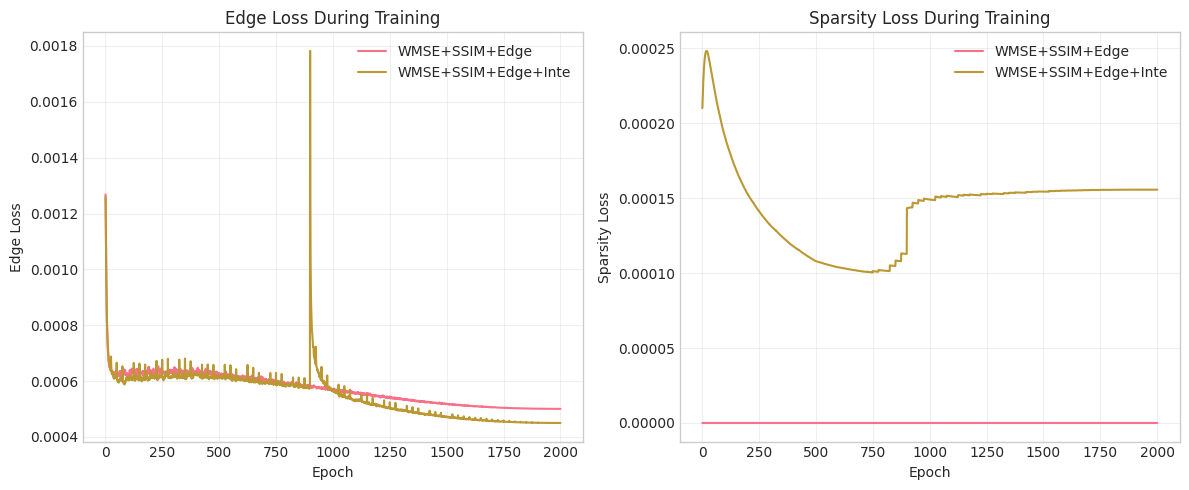

In [17]:
# Analyze edge loss and sparsity for configurations that have them
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Edge loss comparison
ax1 = axes[0]
for name, history in training_histories.items():
    df = pd.DataFrame(history)
    if 'edge' in df.columns:
        ax1.plot(range(1, len(df)+1), df['edge'], label=name, linewidth=1.5)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Edge Loss')
ax1.set_title('Edge Loss During Training')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sparsity comparison
ax2 = axes[1]
for name, history in training_histories.items():
    df = pd.DataFrame(history)
    if 'sparsity' in df.columns:
        ax2.plot(range(1, len(df)+1), df['sparsity'], label=name, linewidth=1.5)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sparsity Loss')
ax2.set_title('Sparsity Loss During Training')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_edge_sparsity.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Checkpoint File Analysis

In [18]:
import torch

# Analyze best checkpoints from each configuration
checkpoint_analysis = []

for name, path in ablation_configs.items():
    # Find the best checkpoint file
    best_ckpt = None
    for f in path.iterdir():
        if 'best' in f.name and f.suffix == '.pt':
            best_ckpt = f
            break
    
    if best_ckpt and best_ckpt.exists():
        ckpt = torch.load(best_ckpt, map_location='cpu')
        
        # Extract useful info
        n_gaussians = None
        if 'means' in ckpt:
            n_gaussians = ckpt['means'].shape[0]
        elif 'state_dict' in ckpt and 'means' in ckpt['state_dict']:
            n_gaussians = ckpt['state_dict']['means'].shape[0]
        
        file_size_mb = best_ckpt.stat().st_size / (1024 * 1024)
        
        checkpoint_analysis.append({
            'Configuration': name,
            'Checkpoint': best_ckpt.name,
            'N Gaussians': n_gaussians,
            'File Size (MB)': f"{file_size_mb:.2f}",
            'Keys': list(ckpt.keys()) if isinstance(ckpt, dict) else 'N/A',
        })
        
        print(f"\n{name}:")
        print(f"  Checkpoint: {best_ckpt.name}")
        print(f"  N Gaussians: {n_gaussians}")
        print(f"  File Size: {file_size_mb:.2f} MB")

checkpoint_df = pd.DataFrame(checkpoint_analysis)
checkpoint_df


WMSE:
  Checkpoint: splat_wmse_best.pt
  N Gaussians: 47817
  File Size: 2.01 MB

WMSE+SSIM:
  Checkpoint: splat_wsme_ssim_best.pt
  N Gaussians: 47564
  File Size: 2.00 MB

WMSE+SSIM+Edge:
  Checkpoint: splat_swme_ssim_edge_best.pt
  N Gaussians: 47564
  File Size: 2.00 MB

WMSE+SSIM+Edge+Inte:
  Checkpoint: splat_swme_ssim_edge_inte_best.pt
  N Gaussians: 41471
  File Size: 1.74 MB


,Configuration,Checkpoint,N Gaussians,File Size (MB),Keys
0,WMSE,splat_wmse_best.pt,47817,2.01,"[means, log_scales, quaternions, log_intensiti..."
1,WMSE+SSIM,splat_wsme_ssim_best.pt,47564,2.00,"[means, log_scales, quaternions, log_intensiti..."
2,WMSE+SSIM+Edge,splat_swme_ssim_edge_best.pt,47564,2.00,"[means, log_scales, quaternions, log_intensiti..."
3,WMSE+SSIM+Edge+Inte,splat_swme_ssim_edge_inte_best.pt,41471,1.74,"[means, log_scales, quaternions, log_intensiti..."


## 8. Final Summary

In [19]:
# Print final summary
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY")
print("="*80)

best_config = convergence_df['Best PSNR'].idxmax()
best_ssim_config = convergence_df['Best SSIM'].idxmax()

print(f"\nBest PSNR Configuration: {best_config}")
print(f"  - PSNR: {convergence_df.loc[best_config, 'Best PSNR']:.2f} dB")
print(f"  - SSIM: {convergence_df.loc[best_config, 'Best SSIM']:.4f}")

print(f"\nBest SSIM Configuration: {best_ssim_config}")
print(f"  - SSIM: {convergence_df.loc[best_ssim_config, 'Best SSIM']:.4f}")
print(f"  - PSNR: {convergence_df.loc[best_ssim_config, 'Best PSNR']:.2f} dB")

# Improvement from baseline
baseline = convergence_df.loc['WMSE']
full = convergence_df.loc['WMSE+SSIM+Edge+Inte']

print(f"\nImprovement from Baseline (WMSE) to Full Model:")
print(f"  - PSNR: +{full['Best PSNR'] - baseline['Best PSNR']:.2f} dB")
print(f"  - SSIM: +{(full['Best SSIM'] - baseline['Best SSIM']):.4f}")
print("="*80)


ABLATION STUDY SUMMARY

Best PSNR Configuration: WMSE+SSIM+Edge+Inte
  - PSNR: 38.39 dB
  - SSIM: 0.9944

Best SSIM Configuration: WMSE+SSIM+Edge+Inte
  - SSIM: 0.9944
  - PSNR: 38.39 dB

Improvement from Baseline (WMSE) to Full Model:
  - PSNR: +0.25 dB
  - SSIM: +0.0040


## 9. Training vs Validation: Overfitting Analysis

In [20]:
# Extract training vs validation metrics to detect overfitting
overfitting_data = []

for name, history in training_histories.items():
    df = pd.DataFrame(history)
    
    # Check if validation metrics exist
    has_val = 'val_psnr' in df.columns and df['val_psnr'].notna().any()
    
    # Get final training metrics
    final_train_psnr = df['psnr'].iloc[-1]
    final_train_ssim = df['ssim'].iloc[-1]
    final_train_mae = df['mae'].iloc[-1]
    
    # Get best training metrics
    best_train_psnr = df['psnr'].max()
    best_train_ssim = df['ssim'].max()
    best_train_mae = df['mae'].min()
    
    if has_val:
        # Get validation metrics (filter NaN values)
        val_df = df[df['val_psnr'].notna()]
        final_val_psnr = val_df['val_psnr'].iloc[-1]
        final_val_ssim = val_df['val_ssim'].iloc[-1]
        final_val_mae = val_df['val_mae'].iloc[-1]
        best_val_psnr = val_df['val_psnr'].max()
        best_val_ssim = val_df['val_ssim'].max()
        best_val_mae = val_df['val_mae'].min()
        
        # Calculate gaps (overfitting indicators)
        psnr_gap = final_train_psnr - final_val_psnr
        ssim_gap = final_train_ssim - final_val_ssim
        mae_gap = final_val_mae - final_train_mae
    else:
        final_val_psnr = final_val_ssim = final_val_mae = np.nan
        best_val_psnr = best_val_ssim = best_val_mae = np.nan
        psnr_gap = ssim_gap = mae_gap = np.nan
    
    overfitting_data.append({
        'Configuration': name,
        'Train PSNR (final)': final_train_psnr,
        'Val PSNR (final)': final_val_psnr,
        'PSNR Gap': psnr_gap,
        'Train SSIM (final)': final_train_ssim,
        'Val SSIM (final)': final_val_ssim,
        'SSIM Gap': ssim_gap,
        'Train MAE (final)': final_train_mae,
        'Val MAE (final)': final_val_mae,
        'MAE Gap': mae_gap,
    })

overfitting_df = pd.DataFrame(overfitting_data).set_index('Configuration')
print("Training vs Validation Metrics (Overfitting Analysis):")
print("Positive gaps indicate potential overfitting (train > val for PSNR/SSIM, val > train for MAE)")
print()
overfitting_df

Training vs Validation Metrics (Overfitting Analysis):
Positive gaps indicate potential overfitting (train > val for PSNR/SSIM, val > train for MAE)



,Train PSNR (final),Val PSNR (final),PSNR Gap,Train SSIM (final),Val SSIM (final),SSIM Gap,Train MAE (final),Val MAE (final),MAE Gap
Configuration,,,,,,,,,
WMSE,38.140831,NaN,NaN,0.990364,NaN,NaN,0.002917,NaN,NaN
WMSE+SSIM,38.141286,36.782971,1.358316,0.993903,0.990935,0.002967,0.002580,0.003109,0.000529
WMSE+SSIM+Edge,37.959850,36.856709,1.103141,0.993736,0.991029,0.002707,0.002630,0.003094,0.000464
WMSE+SSIM+Edge+Inte,38.387495,36.901682,1.485813,0.994352,0.990995,0.003357,0.002511,0.003068,0.000557


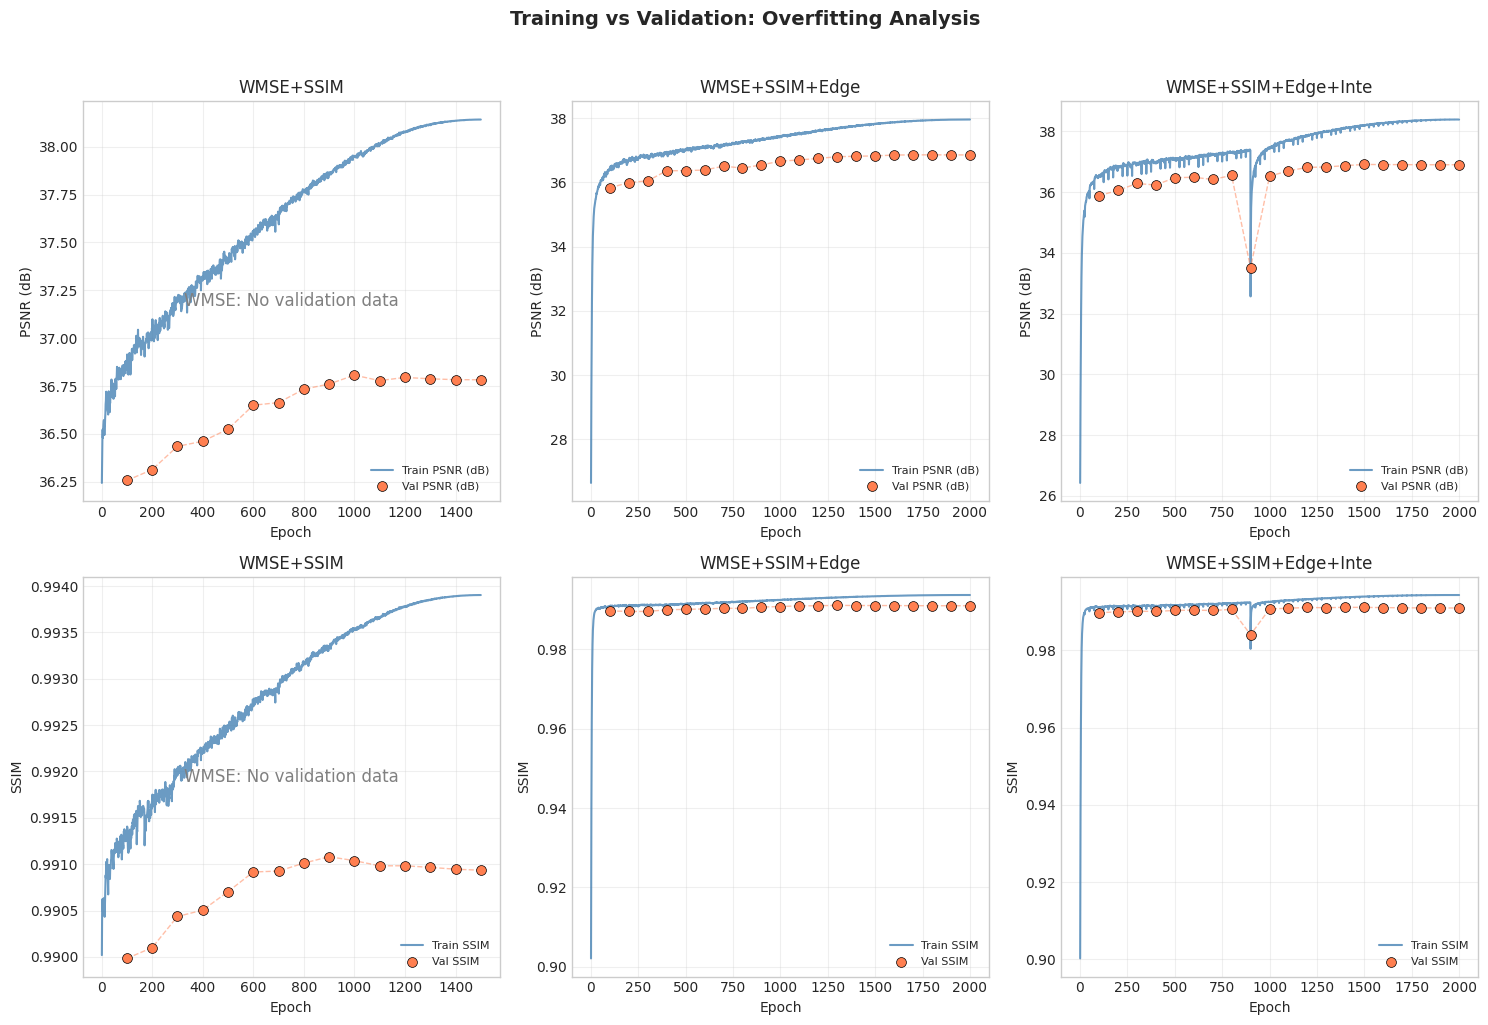

In [ ]:
# Plot training vs validation curves for models with validation data
models_with_val = ['WMSE+SSIM', 'WMSE+SSIM+Edge', 'WMSE+SSIM+Edge+Inte']
fig, axes = plt.subplots(len(models_with_val), 2, figsize=(14, 12))

for row_idx, name in enumerate(models_with_val):
    if name not in training_histories:
        continue
    df = pd.DataFrame(training_histories[name])
    epochs = range(1, len(df)+1)
    
    # PSNR plot
    ax1 = axes[row_idx, 0]
    ax1.plot(epochs, df['psnr'], label='Train PSNR', color='steelblue', alpha=0.8, linewidth=1.5)
    
    if 'val_psnr' in df.columns:
        val_df = df[df['val_psnr'].notna()]
        val_epochs = val_df.index + 1
        ax1.scatter(val_epochs, val_df['val_psnr'], label='Val PSNR', 
                   color='coral', s=60, zorder=5, edgecolors='black', linewidths=0.5)
        ax1.plot(val_epochs, val_df['val_psnr'], color='coral', alpha=0.5, linestyle='--', linewidth=1)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title(f'{name} - PSNR')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # SSIM plot
    ax2 = axes[row_idx, 1]
    ax2.plot(epochs, df['ssim'], label='Train SSIM', color='steelblue', alpha=0.8, linewidth=1.5)
    
    if 'val_ssim' in df.columns:
        val_df = df[df['val_ssim'].notna()]
        val_epochs = val_df.index + 1
        ax2.scatter(val_epochs, val_df['val_ssim'], label='Val SSIM', 
                   color='coral', s=60, zorder=5, edgecolors='black', linewidths=0.5)
        ax2.plot(val_epochs, val_df['val_ssim'], color='coral', alpha=0.5, linestyle='--', linewidth=1)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('SSIM')
    ax2.set_title(f'{name} - SSIM')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Training vs Validation Curves: Overfitting Analysis', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('ablation_overfitting_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Overfitting summary table
print("\n" + "="*80)
print("OVERFITTING ANALYSIS SUMMARY")
print("="*80)

# Create a formatted summary
summary_rows = []
for name in ['WMSE', 'WMSE+SSIM', 'WMSE+SSIM+Edge', 'WMSE+SSIM+Edge+Inte']:
    row = overfitting_df.loc[name]
    
    if pd.isna(row['PSNR Gap']):
        status = "No validation data"
        psnr_gap_str = "N/A"
        ssim_gap_str = "N/A"
    else:
        psnr_gap = row['PSNR Gap']
        ssim_gap = row['SSIM Gap']
        psnr_gap_str = f"{psnr_gap:+.2f} dB"
        ssim_gap_str = f"{ssim_gap:+.4f}"
        
        # Determine overfitting status
        if psnr_gap > 2.0 or ssim_gap > 0.02:
            status = "⚠️ Significant Overfitting"
        elif psnr_gap > 1.0 or ssim_gap > 0.01:
            status = "⚡ Mild Overfitting"
        elif psnr_gap > 0.5 or ssim_gap > 0.005:
            status = "✓ Minor Gap"
        else:
            status = "✓ Well Generalized"
    
    summary_rows.append({
        'Configuration': name,
        'Train PSNR': f"{row['Train PSNR (final)']:.2f}",
        'Val PSNR': f"{row['Val PSNR (final)']:.2f}" if not pd.isna(row['Val PSNR (final)']) else "N/A",
        'PSNR Gap': psnr_gap_str,
        'Status': status,
    })

summary_table = pd.DataFrame(summary_rows)
print(summary_table.to_string(index=False))
print("="*80)
print("\nInterpretation:")
print("  - PSNR Gap = Train PSNR - Val PSNR (positive = overfitting)")
print("  - Gap < 0.5 dB: Well generalized")
print("  - Gap 0.5-1.0 dB: Minor gap, acceptable")
print("  - Gap 1.0-2.0 dB: Mild overfitting, consider regularization")
print("  - Gap > 2.0 dB: Significant overfitting, needs attention")


OVERFITTING ANALYSIS SUMMARY
      Configuration Train PSNR Val PSNR PSNR Gap             Status
               WMSE      38.14      N/A      N/A No validation data
          WMSE+SSIM      38.14    36.78 +1.36 dB ⚡ Mild Overfitting
     WMSE+SSIM+Edge      37.96    36.86 +1.10 dB ⚡ Mild Overfitting
WMSE+SSIM+Edge+Inte      38.39    36.90 +1.49 dB ⚡ Mild Overfitting

Interpretation:
  - PSNR Gap = Train PSNR - Val PSNR (positive = overfitting)
  - Gap < 0.5 dB: Well generalized
  - Gap 0.5-1.0 dB: Minor gap, acceptable
  - Gap 1.0-2.0 dB: Mild overfitting, consider regularization
  - Gap > 2.0 dB: Significant overfitting, needs attention


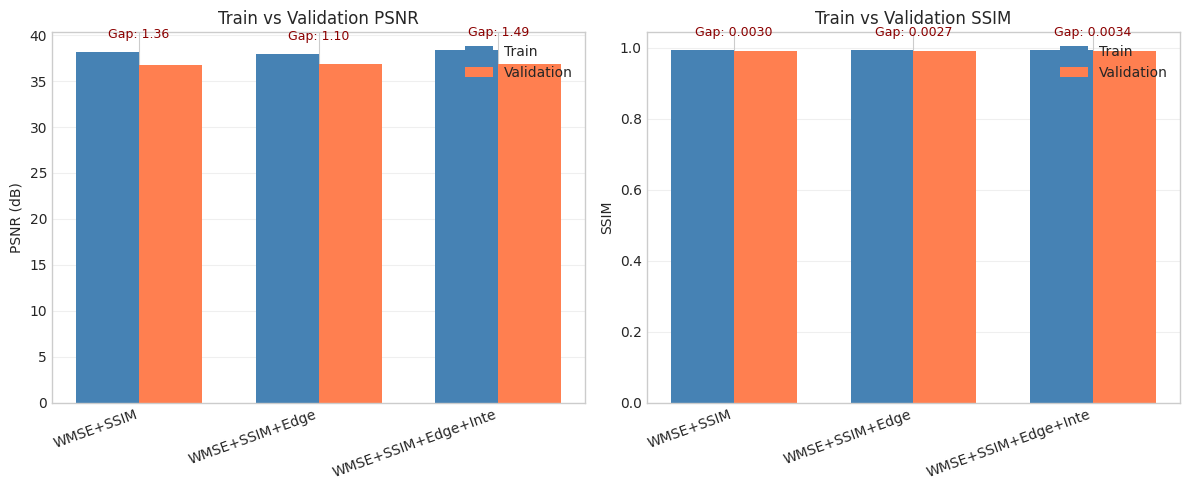

In [23]:
# Bar chart comparing train vs validation metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Prepare data for models with validation
models_with_val = ['WMSE+SSIM', 'WMSE+SSIM+Edge', 'WMSE+SSIM+Edge+Inte']
x = np.arange(len(models_with_val))
width = 0.35

# PSNR comparison
ax1 = axes[0]
train_psnr = [overfitting_df.loc[m, 'Train PSNR (final)'] for m in models_with_val]
val_psnr = [overfitting_df.loc[m, 'Val PSNR (final)'] for m in models_with_val]

bars1 = ax1.bar(x - width/2, train_psnr, width, label='Train', color='steelblue')
bars2 = ax1.bar(x + width/2, val_psnr, width, label='Validation', color='coral')

ax1.set_ylabel('PSNR (dB)')
ax1.set_title('Train vs Validation PSNR')
ax1.set_xticks(x)
ax1.set_xticklabels(models_with_val, rotation=20, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add gap annotations
for i, (t, v) in enumerate(zip(train_psnr, val_psnr)):
    gap = t - v
    ax1.annotate(f'Gap: {gap:.2f}', xy=(i, max(t, v)), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=9, color='darkred')

# SSIM comparison
ax2 = axes[1]
train_ssim = [overfitting_df.loc[m, 'Train SSIM (final)'] for m in models_with_val]
val_ssim = [overfitting_df.loc[m, 'Val SSIM (final)'] for m in models_with_val]

bars3 = ax2.bar(x - width/2, train_ssim, width, label='Train', color='steelblue')
bars4 = ax2.bar(x + width/2, val_ssim, width, label='Validation', color='coral')

ax2.set_ylabel('SSIM')
ax2.set_title('Train vs Validation SSIM')
ax2.set_xticks(x)
ax2.set_xticklabels(models_with_val, rotation=20, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add gap annotations
for i, (t, v) in enumerate(zip(train_ssim, val_ssim)):
    gap = t - v
    ax2.annotate(f'Gap: {gap:.4f}', xy=(i, max(t, v)), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.savefig('ablation_train_val_comparison.png', dpi=150, bbox_inches='tight')
plt.show()